<a href="https://colab.research.google.com/github/k-randl/conformal_prompting/blob/main/demo/cicle_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Saving prompting resources with CICLe 

In this tutorial, we show how to reduce the cost of few-shot text classification with CICLe, a method introduced in our paper "[CICLe: Conformal In-Context Learning for Largescale Multi-Class Food Risk Classification](https://doi.org/10.18653/v1/2024.findings-acl.459)."

CICLe is a framework that optimizes the way we use LLMs for large-scale, multi-class classification tasks. It combines the power of Conformal Prediction (CP) with in-context learning, allowing the system to make accurate predictions with fewer resources than would be necessary for native few-shot classification. The main idea is to reduce the size of the prompts given to the LLM without losing classification accuracy.

## 1. Theory

CICLe works by involving a base classifier, like a Logistic Regression model, that makes an initial prediction. If the classifier is confident, only a small, relevant set of classes is passed on to the LLM for further refinement. This interaction helps reduce the need to process massive amounts of data, which in turn saves computational power.
Moreover, CICLe uses Conformal Prediction to ensure that the true class is likely included in this shortlist, helping to maintain high accuracy even with fewer class examples in the prompt.

**The benefits of CICLe are twofold:**

- Improved Efficiency: CICLe reduces the computational load by trimming down the size of prompts sent to the LLM, saving time and energy while retaining accuracy.
- Better Handling of Low-Support Classes: CICLe shines in complex tasks with a mix of high-support (that have lots of training examples) and low-support classes (that have very few training examples) where traditional machine learning models typically struggle.

**The general method of CICLe is described in the following graphic:**

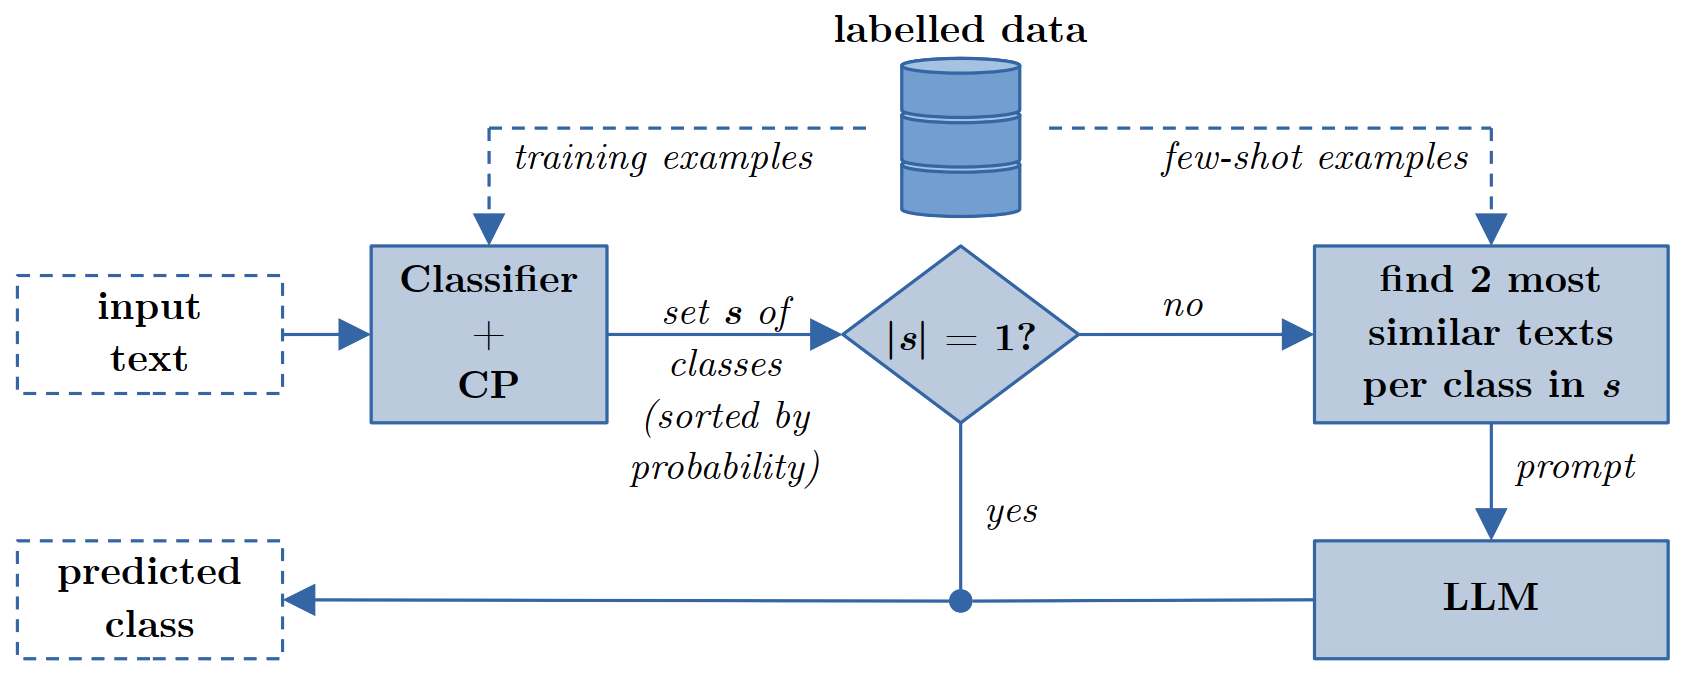

We first classify each text with a simple (weak) classifier. This classifier is enhanced with Conformal Prediction and therefore returns sets of classes that contain the true class of the text with the probability $p=(1-\alpha)$ ($\alpha$ is a parameter chosen by the user). The size of these sets increases with the classifier's uncertainty of the assessed text and has a minimum of 1.
If the set contains only one class (as the base classifier is very certain) we can directly predict that class.
If the set size is greater than 1, we use few-shot prompting with an LLM to find the right one: for each class in the predicted set, we find the most similar texts from our labelled training data to build a few-shot prompt. 

## 2. Implementation

Now that we know what it is all about, let's go through how to set it up step by step!

### Prerequisites:

Before we dive into the implementation, we have to install some prerequisistes:

 - we use [pandas](https://pandas.pydata.org/docs/) to easily load and format our data
 - we use the [crepes](https://github.com/henrikbostrom/crepes) library together with [scikit-learn](https://scikit-learn.org/stable/api/index.html) to implement our conformal base classifier
 - we use Meta's open source LLM [Llama 3.1](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct) for prompting

Furthermore, we will perform our experiments on the [Food Recall Incidents Dataset](https://doi.org/10.5281/zenodo.10891602)

In [ ]:
# install dependecies:
%pip install numpy torch pandas scikit-learn crepes transformers tqdm

# download dataset:
!wget https://zenodo.org/records/10891602/files/food_recall_incidents.csv

### Prepare data

Let's start with importing the pandas library and loading our downloaded data into a pandas `DataFrame`, using the first column as the index (index_col=0). Finally, we use the `.sample()` method to randomly select and display one row from the dataset.

In [2]:
import pandas as pd

data = pd.read_csv('food_recall_incidents.csv', index_col=0)
data.sample()

year  month  day                         title         product  \
2621  2018      2   16  enerBIO Tortilla Chips Natur  tortilla chips   

     product-category product-title  \
2621    confectionery        (8,21)   

                                              hazard hazard-category  \
2621  cereals containing gluten and products thereof       allergens   

     hazard-title language country  
2621          NaN       de      de

In this tutorial we will predict the `product-category` from the `title` of the food recall:

In [3]:
# select input and label from data:
X = data['title'].to_numpy()
y = data['product-category'].to_numpy()

We use `train_test_split` from `sklearn.model_selection` to split our data. First, we create the test set by splitting `X` and `y` into `X_test` and `y_test` with 20% allocated to the test set, ensuring shuffling and stratification. We print their shapes to verify the sizes.

Next, we split the remaining data into training `(X_train, y_train)` and development sets `(X_dev, y_dev)`, again using 20% for the development set, followed by printing their shapes for verification.

In [4]:
from sklearn.model_selection import train_test_split

# create test set:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, shuffle=True, stratify=y)
print('Size of test set:       ', X_test.shape)

# create train and development sets:
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=.2, shuffle=True, stratify=y)
print('Size of development set:', X_dev.shape)
print('Size of train set:      ', X_train.shape)

Size of test set:        (1197,)
Size of development set: (958,)
Size of train set:       (3829,)


### Train base classifier

We import TfidfVectorizer from `sklearn.feature_extraction.text` and use it to create and fit a TF-IDF input embedding on the `X_train` data. Since `TfidfVectorizer.transform(...)` returns a sparse matrix, which is incompatible with 'crepes', we define a utility function (`phi`) to convert the sparse matrix into a dense array using `.toarray()`.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create and train input embedding:
tfidf = TfidfVectorizer().fit(X_train)

# since TfidfVectorizer.transform(...) returns a sparse matrix which 'crepes'
# does not handle well, we use the following utility function to encode our texts:
phi = lambda x: tfidf.transform(x).toarray()

# print a sample of the vocabulary to show that we learned something:
list(tfidf.vocabulary_.keys())[:5]

['the', 'co', 'operative', 'food', 'loved']

Now let's create a list of unique labels (`id2label`) from the training labels `y_train`. We then build a dictionary (`label2id`) that maps each label to a unique ID using enumeration. Finally, we display the label-to-ID mapping by printing `label2id`.

In [6]:
import numpy as np

# create label to one-hot and reverse dictionaries:
id2label = np.unique(y_train)
label2id = {l:i for i, l in enumerate(id2label)}

# show label-id mapping:
label2id

{'alcoholic beverages': 0,
 'cereals and bakery products': 1,
 'cocoa and cocoa preparations, coffee and tea': 2,
 'confectionery': 3,
 'dietetic foods, food supplements, fortified foods': 4,
 'fats and oils': 5,
 'feed materials': 6,
 'food additives and flavourings': 7,
 'food contact materials': 8,
 'fruits and vegetables': 9,
 'herbs and spices': 10,
 'honey and royal jelly': 11,
 'ices and desserts': 12,
 'meat, egg and dairy products': 13,
 'non-alcoholic beverages': 14,
 'nuts, nut products and seeds': 15,
 'other food product / mixed': 16,
 'pet feed': 17,
 'prepared dishes and snacks': 18,
 'seafood': 19,
 'soups, broths, sauces and condiments': 20,
 'sugars and syrups': 21}

Now let's train our conformal base classifier! In this tutorial we use the `WrapClassifier` class from `crepes` and the `LogisticRegression` class from `sklearn.linear_model`. First, we create a conformal classifier (`base_classifier`) by wrapping a `LogisticRegression` model.

Next, we train the classifier using the transformed training data (`phi(X_train)`) and the corresponding labels (`label2id[y_train]`).

Finally, we calibrate the classifier on the development set (`phi(X_dev)`) with the corresponding labels, using class-conditional calibration (`class_cond=True`).

In [ ]:
from crepes import WrapClassifier
from sklearn.linear_model import LogisticRegression

# create a conformal base classifier based on Logistic Regression:
base_classifier = WrapClassifier(LogisticRegression())

# train the base classifier:
base_classifier.fit(
    phi(X_train),
    [label2id[y] for y in y_train]
)

# calibrate the base classifier:
base_classifier.calibrate(
    phi(X_dev),
    [label2id[y] for y in y_dev],
    class_cond=True
)

### Instantiate Llama

In order to be able to use huggingface's Llama 3.1 models, we first need to log in to huggingface (you can request access to the model [here](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct)).

In [ ]:
import getpass
from huggingface_hub import login
login(getpass.getpass('Enter your huggingface API-key:'))

In this tutorial we will use the standard huggingface textgeneration pipeline (compressed to 16 bit floating point weights) for the instruction tuned 8B parameter version of Llama 3.1.

In [ ]:
import transformers
import torch

# create llm pipeline:
llm = transformers.pipeline(
    "text-generation",
    model="meta-llama/Meta-Llama-3.1-8B-Instruct",
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="auto"
)

# Get special tokens for later:
bos_token_id = llm.tokenizer.convert_tokens_to_ids('<|begin_of_text|>')
eos_token_id = llm.tokenizer.convert_tokens_to_ids('<|eot_id|>')
pad_token_id = llm.tokenizer.convert_tokens_to_ids('<|eot_id|>')

### CICLe

The main part of the CICLe fuctionality is implemented in the following function `get_few_shot_examples`. It takes a given `text`, a set of predictions (`prediction_set`) created by assessing `text` with our conformal classifier, and an optional number of examples per class (`examples_per_class`, default 2). It identifies and returns the most similar training examples for each class in the prediction set.

For each class (`y`) in the prediction set:

1. We extract the texts from `X_train` that belong to the current class (`y_train == y`).
2. We compute embeddings for the provided text and the class texts using `phi()`.
3. We calculate cosine similarity between the embeddings.
4. The closest training examples are selected based on similarity and appended to the list of examples.

Finally, the examples are sorted by similarity in descending order, and the function returns them.

In [10]:
from sklearn.metrics import pairwise_distances

def get_few_shot_examples(text, prediction_set, examples_per_class=2):
    examples = []

    for y in prediction_set:
        # get texts in current class:
        texts = X_train[y_train == y]

        # generate embeddings of texts in class:
        embeddings = phi([text] + texts.tolist())

        # calculate cosine-similaity:
        similarity = (1. - pairwise_distances(embeddings, metric='cosine'))[1:,0]

        # get closest sample of training data based on embeddings:
        for j in np.argsort(similarity)[::-1][:examples_per_class]:
            examples.append((texts[j], y, similarity[j]))

    # sort samples based on embedding from training data:
    examples.sort(key=lambda e: e[2], reverse=True)

    return examples

# print sample output:
samples = get_few_shot_examples(
    X_test[0],
    id2label[base_classifier.predict_set(phi(X_test[:1])).astype(bool)[0]]
)
samples

[("Snapp's Ferry Packing Company Recalls Beef Product Due To Possible E. Coli O157:H7 Contamination",
  'meat, egg and dairy products',
  0.5964571175609005),
 ('Swift Beef Company Recalls Ground Beef Products due to Possible E. Coli O157:H7 Contamination',
  'meat, egg and dairy products',
  0.5836284020777329),
 ('Ginco recalls its Chocolate Coated Honeycomb 100g due to undeclared allergens',
  'honey and royal jelly',
  0.04334539497098766),
 ('Various brands of Palm Oil recalled due to Salmonella - Recalls, advisories and safety alerts – Canada.ca',
  'fats and oils',
  0.042516452755963385),
 ('pregel america, inc. issues allergy alert on undeclared milk in lemon 50',
  'food additives and flavourings',
  0.04203915043391382),
 ('Rogers brand Golden Yellow Sugar recalled due to pieces of plastic - Recalls, advisories and safety alerts – Canada.ca',
  'sugars and syrups',
  0.03747092322805878),
 ('CFS urges public not to consume stabiliser from France with possible presence of eth

The `create_prompt` function generates a formatted prompt for classification tasks using a given text and labeled examples.

1. The function creates a context string, which introduces the task and includes labeled examples provided in the examples list, sorted by probability.
2. Each example is appended to the context in the format `"<example text>" => <class label>` (hence we need to use a helper function, `replace_qm`, to replace double quotes (`"`) with single quotes (`'`) in the text).
3. Finally, it returns a dictionary formatted for a user prompt, asking to predict the class label for the input text, which is also cleaned of double quotes.

In [11]:
def create_prompt(text, examples):
    # helper function replacing quotation marks in the text:
    replace_qm = lambda s: s.replace('"', "'")

    # create context:
    context = f'We are looking for food products in texts. Here are some labelled examples sorted from most probable to least probable:\n'

    for x, y, _ in examples:
        context += f'\n"{replace_qm(x)}" => {y}'

    return {"role": "user", "content": f'{context}\n\nPlease predict the correct class for the following sample. Only provide the class label.\n\n"{replace_qm(text)}" => '}

# print sample prompt:
print(create_prompt(X_test[0], samples)["content"])

We are looking for food products in texts. Here are some labelled examples sorted from most probable to least probable:

"Snapp's Ferry Packing Company Recalls Beef Product Due To Possible E. Coli O157:H7 Contamination" => meat, egg and dairy products
"Swift Beef Company Recalls Ground Beef Products due to Possible E. Coli O157:H7 Contamination" => meat, egg and dairy products
"Ginco recalls its Chocolate Coated Honeycomb 100g due to undeclared allergens" => honey and royal jelly
"Various brands of Palm Oil recalled due to Salmonella - Recalls, advisories and safety alerts – Canada.ca" => fats and oils
"pregel america, inc. issues allergy alert on undeclared milk in lemon 50" => food additives and flavourings
"Rogers brand Golden Yellow Sugar recalled due to pieces of plastic - Recalls, advisories and safety alerts – Canada.ca" => sugars and syrups
"CFS urges public not to consume stabiliser from France with possible presence of ethylene oxide" => food additives and flavourings
"Recall

Now it's time to calculate the conformal prediction sets for our test data:

In [12]:
# calculate prediction sets:
ps_test = [id2label[s.astype(bool)] for s in base_classifier.predict_set(phi(X_test))]

Finally, we put all pieces together to predict labels for the test set (`X_test`) using CICLe.

1. For each text (`x`) in X_test and its associated prediction set (`ps`), the function `get_few_shot_examples` retrieves two of the most similar training examples.
2. If at least two examples are found, a prompt is created using `create_prompt()`.
3. The LLM is then used to predict the class label based on this prompt, and the result is added to the predictions list.
4. If there is only one class in the prediction set, it is directly used as the prediction.

In [ ]:
from tqdm.notebook import tqdm

# predict test set:
predictions = []
for x, ps in tqdm(zip(X_test, ps_test), total=len(X_test), desc='Assessing texts'):
    # get 2 most similar texts in the training data:
    examples = get_few_shot_examples(x, ps)

    if len(examples) > 1:
        # create prompt:
        prompt = create_prompt(x, examples)

        # prompt LLM:
        predictions.append(llm([prompt],
            bos_token_id=bos_token_id,
            eos_token_id=eos_token_id,
            pad_token_id=pad_token_id,
            max_new_tokens=32,
            do_sample=False,
            temperature=None,
            top_p=None
        )[0]["generated_text"][-1]["content"])

    else: predictions.append(examples[0])

In our paper CICLe was tested on food risk classification, a task involving classifying food recall announcements into hundreds of fine-grained categories. In this scenario, CICLe outperformed other models, achieving comparable or better accuracy while drastically cutting down on computational resources.

CICLe shows us that we don’t always need brute force computing to get the best results — sometimes, it’s all about using smarter strategies.